# TLDR: 
Use this notebook to download a Canopy Height Map as a geotiff for a user define polygon from the global dataset (https://registry.opendata.aws/dataforgood-fb-forests/, browsable here: https://meta-forest-monitoring-okw37.projects.earthengine.app/view/canopyheight). 


# Details: 

- Given a polygon (in the form of a geojson), this notebook will go through the process of downloading the appropriate geotiffs from AWS S3, along with the associated metadata files and cloud masks.
- The geotiffs on S3 are stored as web mercator tiles, and this notebook will merge those tiled geotiffs (if necessary for the given polygon) and then crop down to the region specfied by the input polygon.
- The final product is a geotiff that has been cropped and cloud masked as needed, given potential clouds in the input imagery.

# Reference 
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/

In [17]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config
import pandas as pd
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.merge import merge
import rasterio.mask
from PIL import Image
from pyproj import Transformer
from shapely.geometry import box
from shapely.geometry import box, GeometryCollection, MultiPolygon, polygon, shape
import json
import shutil

In [60]:
def bounding_box_to_geojson(bbox):
    """
    Convert a bounding box [lat1, lon1, lat2, lon2] to a GeoJSON Polygon.
    Assumes lat1/lon1 is one corner, lat2/lon2 is the opposite corner.
    """
    lat1, lon1, lat2, lon2 = bbox

    # Ensure correct ordering: south, west, north, east
    south = min(lat1, lat2)
    north = max(lat1, lat2)
    west = min(lon1, lon2)
    east = max(lon1, lon2)

    # Define the polygon coordinates (must be closed: first point == last point)
    coordinates = [[
        [west, south],
        [east, south],
        [east, north],
        [west, north],
        [west, south]
    ]]

    geojson = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": coordinates
        },
        "properties": {}
    }

    return geojson

# Example usage:
bbox = [39.304083043961384, -84.49987615088783, 39.303768285158064, -84.49958991658588]
geojson = bounding_box_to_geojson(bbox)
print(json.dumps(geojson, indent=2))


{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -84.49987615088783,
          39.303768285158064
        ],
        [
          -84.49958991658588,
          39.303768285158064
        ],
        [
          -84.49958991658588,
          39.304083043961384
        ],
        [
          -84.49987615088783,
          39.304083043961384
        ],
        [
          -84.49987615088783,
          39.303768285158064
        ]
      ]
    ]
  },
  "properties": {}
}


<Axes: >

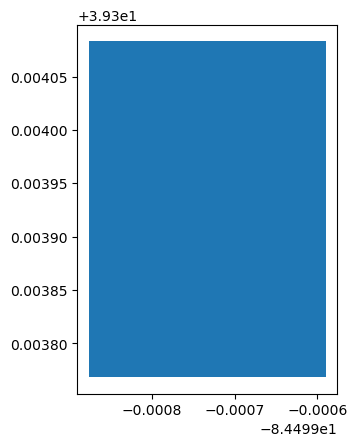

In [61]:
bbox = [39.304083043961384, -84.49987615088783, 39.303768285158064, -84.49958991658588]
geojson = bounding_box_to_geojson(bbox)

# Save to GeoJSON file
with open('bounding_box.geojson', 'w') as f:
    json.dump(geojson, f)

# Read and plot using GeoPandas
gdf = gp.read_file('bounding_box.geojson')
gdf.plot()


In [62]:
# a few raster functions

def merge_rasters(files, outfile: str = "test.tif") -> None:
    """
    Merge a list of geotiffs into one file
    """
    src_files_to_mosaic = []
    for fp in files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    crs = src.crs
    out_meta = src.meta.copy()
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Update the metadata
    out_meta.update(
        {
            "driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "crs": crs,
        }
    )

    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(mosaic)

def crop_raster(rasterfile: str, aoifile:str, outfile: str = "test.tif", nodata=255):
    gdf_aoi=gp.read_file(aoifile)
    with rasterio.open(rasterfile) as src:
            out_meta = src.meta.copy()
            if not src.crs == gdf_aoi.crs:
                gdf_aoi=gdf_aoi.to_crs(src.crs)
            aoi=gdf_aoi.iloc[0].geometry
            im, trans = rasterio.mask.mask(
                src, [aoi], crop=True, nodata=nodata, all_touched=True
            )
            # Update the metadata
            out_meta.update(
            {
                "driver": "GTiff",
                "height": im.shape[1],
                "width": im.shape[2],
                "transform": trans,
                "crs": src.crs,
                "nodata": nodata,
            }
            )
    with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE", BIGTIFF='YES') as dest:
        dest.write(im)


def enforce_mask(file, outfile=None, nodata=255):
    if not outfile:
        outfile=file.replace('.tif', 'masked.tif')
    with rasterio.open(file) as src:
        mask=src.read_masks()
        data=src.read()
        # print the size of the data amd mask
        print(data.shape, mask.shape)
        #nodata has been assigned as 255 in the S3 .msk files
        data[mask==255]=nodata
        out_meta=src.meta
        out_meta.update(
            {"nodata":nodata}
        )
        print(data.shape, mask.shape)
        print(out_meta)
        with rasterio.open(outfile, "w", **out_meta, compress="DEFLATE") as dest:
            print(data)
            dest.write(data)
        # print the size of the outfile
        print(f"Masked raster saved to {outfile} with size {os.path.getsize(outfile)} bytes")

In [63]:
local_tif_dir= '/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/chm'
local_msk_dir= '/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/msk'
local_meta_dir= '/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/metadata'
localdir='saved_data'
# if localdir does not exist, create it
if not os.path.exists(localdir):
    os.makedirs(localdir)

In [101]:

shutil.copy('/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/msk/023010120.tif.msk', 'data_1/023010120.tif.msk')
shutil.copy('/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/chm/023010120.tif', 'data_1/023010120.tif')
# copy '/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/metadata/023010120.geojson' and paste to data_1
shutil.copy('/home/azureuser/cloudfiles/code/Users/Ruixu_Liu/GEDI/data/metadata/023010120.geojson', 'data_1/023010120.geojson')


'data_1/023010120.geojson'

In [4]:
s3file='forests/v1/alsgedi_global_v6_float/tiles.geojson'
localfile=f"data/{os.path.basename(s3file)}"
tiles=gp.read_file(localfile)

<Axes: >

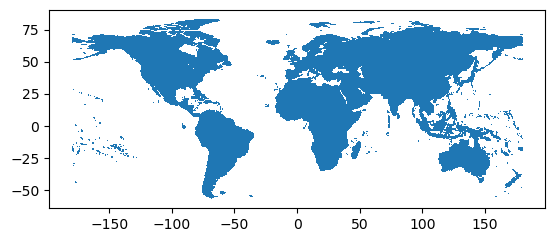

In [5]:
tiles.plot()

In [6]:
tiles

tile                                           geometry
0      023013213  POLYGON ((-115.3125 33.13755, -115.3125 33.724...
1      021210020  POLYGON ((-123.04688 54.57206, -123.04688 54.9...
2      130122211  POLYGON ((115.3125 56.94497, 115.3125 57.32652...
3      121022223  POLYGON ((46.40625 55.77657, 46.40625 56.17002...
4      310111000  POLYGON ((130.07812 -0.70311, 130.07812 0, 129...
...          ...                                                ...
56140  122321030  POLYGON ((30.23438 9.1021, 30.23438 9.79568, 2...
56141  132032310  POLYGON ((106.17188 23.88584, 106.17188 24.527...
56142  300131332  POLYGON ((44.29688 -16.63619, 44.29688 -15.961...
56143  030303300  POLYGON ((-58.35938 50.28934, -58.35938 50.736...
56144  130101111  POLYGON ((123.75 66.23146, 123.75 66.51326, 12...

[56145 rows x 2 columns]

<Axes: >

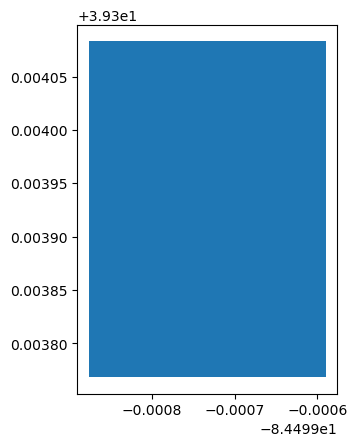

In [64]:
#here is the polygon we are interested in
target_polyfile='bounding_box.geojson'
target=gp.read_file(target_polyfile)
target.plot()

In [65]:
#find tiles that contain the target polygon
target_tiles=gp.sjoin(tiles, target)

In [66]:
target_tiles

tile                                           geometry  \
47651  032000133  POLYGON ((-84.375 38.82259, -84.375 39.36828, ...   

       index_right  
47651            0

In [67]:
tifs = []
metas = []

for ii, row in target_tiles.iterrows():
    tile = row.tile
    print(tile)

    localfile=f"{localdir}/{tile}.tif"
    if not os.path.exists(localfile):
        shutil.copy(f"{local_tif_dir}/{tile}.tif", localfile)
    print(os.path.exists(localfile))
    localmskfile=f"{localdir}/{tile}.tif.msk"
    if not os.path.exists(localmskfile):
        shutil.copy(f"{local_msk_dir}/{tile}.tif.msk", localmskfile)
    print(os.path.exists(localmskfile))
    localjsonfile=f"{localdir}/{tile}.geojson"
    if not os.path.exists(localjsonfile):
        shutil.copy(f"{local_meta_dir}/{tile}.geojson", localjsonfile)
    print(os.path.exists(localjsonfile))

    outfile=f"{localdir}/{tile}masked.tif"
    if not os.path.exists(outfile):
        enforce_mask(localfile, outfile)
    tifs.append(outfile)

032000133
True
True
True
(1, 65536, 65536) (1, 65536, 65536)
(1, 65536, 65536) (1, 65536, 65536)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255, 'width': 65536, 'height': 65536, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(1.1943285669558747, 0.0, -9470853.552646479,
       0.0, -1.194328566955889, 47

In [69]:
#merge all tile tiffs into one continuous tif
mergefile=f"{localdir}/{os.path.basename(target_polyfile).replace('.geojson', '_alltiles.tif')}"
if not os.path.exists(mergefile):
    merge_rasters(tifs, outfile=mergefile)

In [86]:
#crop to bounds of input polygon
cropfile=mergefile.replace('_alltiles.tif', '_crop.tif')
if not os.path.exists(cropfile):
    crop_raster(mergefile, target_polyfile, cropfile)

# plot

In [90]:
with rasterio.open(cropfile) as src:
    data=src.read().squeeze()
    bounds=src.bounds
    width=src.width
    height=src.height

In [91]:
print(width)
print(height)

28
39


In [92]:
factor=1
new_width=int(width/factor)
new_height=int(height/factor)
xx = Image.fromarray(data).resize(
        (new_width, new_height), Image.BICUBIC
    )
chm=np.array(xx).astype('float')
#set nodata (with interp fuzziness)
chm[chm>200]=np.nan

In [93]:
#a few functions for nice looking plots

def mercator_to_latlon_ax(ax, dec=2):
    xt=ax.get_xticks()
    yt=ax.get_yticks()
    trans = Transformer.from_proj("epsg:3857", "epsg:4326")
    #can do this because 3857 has parrallel lat and lon
    zlon=[yt[0] for _ in range(len(xt))]
    zlat=[xt[0] for _ in range(len(yt))]
    _,lon=trans.transform(xt, zlon)
    lat,_=trans.transform(zlat, yt)
    lons=[]
    for l in lon:
        if l<0:
            hem='W'
        else:
            hem='E'
        lons.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")
    lats=[]
    for l in lat:
        if l<0:
            hem='S'
        else:
            hem='N'
        lats.append(f"{np.abs(np.round(l,dec))}{chr(176)}{hem}")

    ax.set_yticklabels(lats, fontsize=18, fontweight="bold")
    ax.set_xticklabels(lons, fontsize=18, fontweight="bold")
    ax.yaxis.set_tick_params(rotation=90)

def geojson_to_poly(geojson):
    """
    Given a geojson with a polygon shape,
    return the shapely object
    """
    if len(geojson["features"]) > 1:
    	poly = GeometryCollection(
            [shape(feature["geometry"]).buffer(0) for feature in geojson["features"]]
        )
    else:
        f = geojson["features"][0]
        poly = shape(f["geometry"]).buffer(0)
    if poly.geom_type != "Polygon":
        pps = []
        for pp in poly.geoms:
            pp = polygon.orient(pp)  # correct winding
            pps.append(pp)
        out_geom = MultiPolygon(pps)
    else:
        out_geom = polygon.orient(poly)  # correct winding
    return out_geom

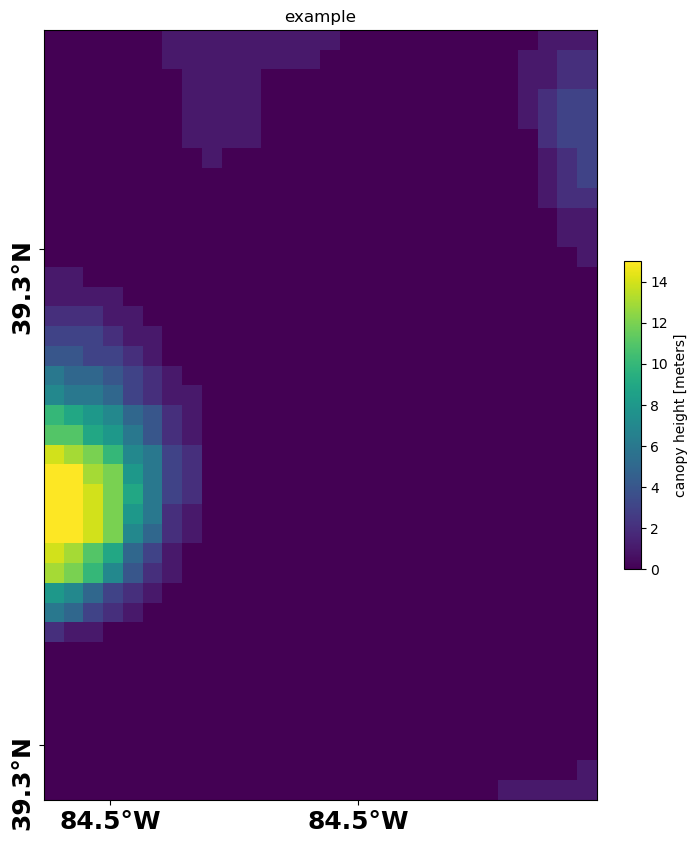

In [94]:
title='example'
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
bbox=box(*bounds)
extent = (bbox.bounds[0], bbox.bounds[2], bbox.bounds[1], bbox.bounds[3])
colors=ax.imshow(chm, vmax=np.nanpercentile(chm,99.5), extent=extent)
tt = ax.get_xticks()[1:-1]
ax.set_xticks(tt[::3])
tt = ax.get_yticks()[1:-1]
ax.set_yticks(tt[::3])
mercator_to_latlon_ax(ax, dec=2)
cax = plt.gca().inset_axes([1.05, 0.3, 0.03, 0.4])
plt.colorbar(colors, cax=cax, label='canopy height [meters]')
ax.set_title(title)
plt.savefig(f'data/{title}.png', dpi=300)

In [98]:
# write code to put data/{title}.png above image.png. 就是把两张图片叠起来， 然后 image.png 在下面， data/{title}.png 在上面， 但是虚化透明一些。
from PIL import Image

def overlay_images(base_path="image.png", overlay_path="data/example.png", output_path="combined_image.png", alpha=0.5):
    """
    Overlay one image on top of another with transparency.
    
    Parameters:
    - base_path: path to the base image (e.g., 'image.png')
    - overlay_path: path to the overlay image (e.g., 'data/example.png')
    - output_path: path to save the combined image
    - alpha: transparency level of the overlay (0 = fully transparent, 1 = fully opaque)
    """
    # Open both images
    base_img = Image.open(base_path).convert("RGBA")
    overlay_img = Image.open(overlay_path).convert("RGBA")

    # Resize overlay to match base image
    overlay_img = overlay_img.resize(base_img.size, Image.BICUBIC)

    # Create a transparent version of the overlay
    transparent_overlay = Image.blend(Image.new("RGBA", base_img.size, (0, 0, 0, 0)), overlay_img, alpha)

    # Combine the images
    combined = Image.alpha_composite(base_img, transparent_overlay)

    # Save the result
    combined.save(output_path)
    print(f"Combined image saved as {output_path}")

# Example usage
overlay_images()


Combined image saved as combined_image.png


# plot observation dates

In [69]:
all_polys=[]
for ff in metas:
    gdf=gp.read_file(ff)
    all_polys.append(gp.overlay(gdf, target))
meta_gdf=pd.concat(all_polys)

ValueError: No objects to concatenate

NameError: name 'meta_gdf' is not defined

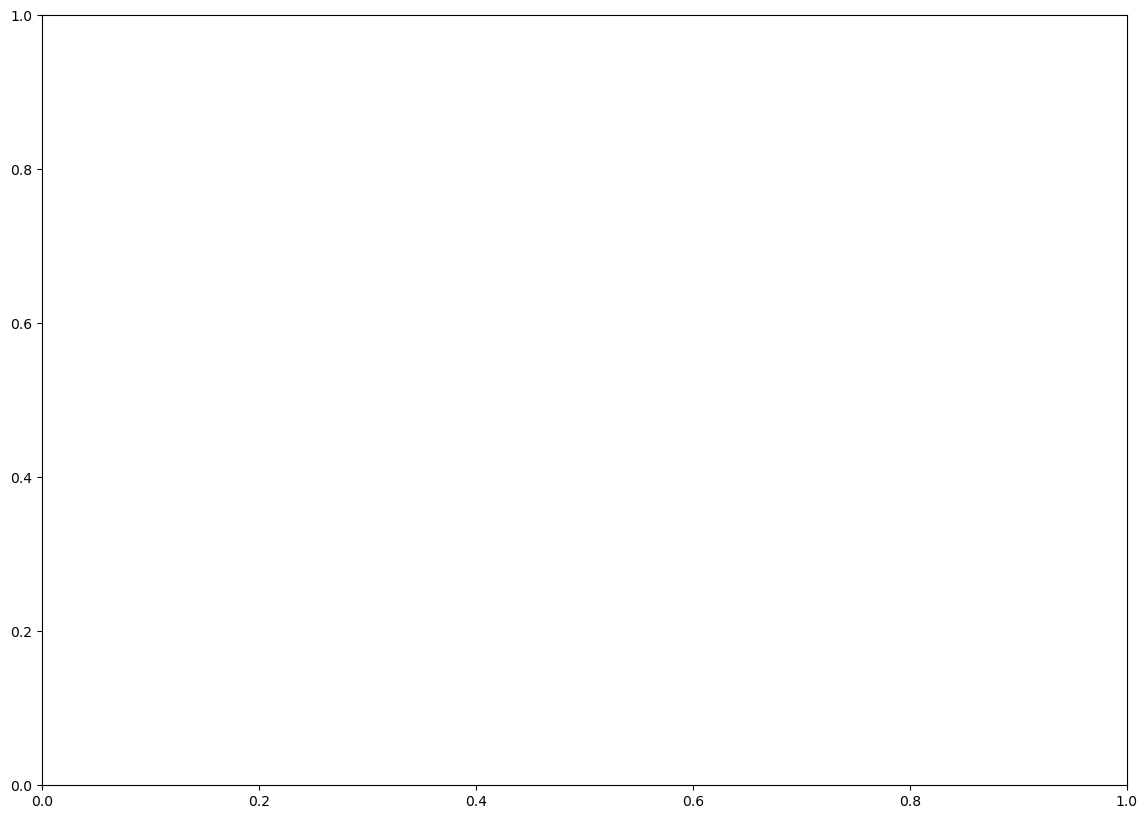

In [51]:
fig, ax = plt.subplots(1, 1, figsize=[14, 10])
meta_gdf.plot(ax=ax, column="acq_date", cmap='viridis', legend=True)
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')
ax.spines[['right', 'top']].set_visible(False)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 0., 0.2, 0.2))
plt.savefig(f'data/{title}_obsdate.png', dpi=300)

/anaconda/envs/chm_demo/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/anaconda/envs/chm_demo/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


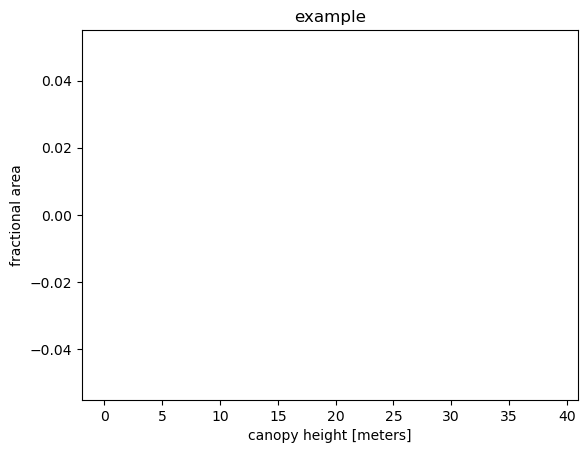

In [70]:
#histogram of canopy height across area
chm_flat=chm.flatten()
bins=np.arange(0,40)
plt.hist(chm_flat, bins=bins, weights=np.ones(len(chm_flat)) / len(chm_flat))
plt.xlabel('canopy height [meters]')
plt.ylabel('fractional area')
plt.title(title)
plt.savefig(f'data/{title}_hist.png', dpi=300)

In [15]:
import geemap

In [11]:
import ee
import folium
from folium import plugins

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

# Define the bounding box (example: part of the Amazon rainforest)
# Replace with your own coordinates: [west, south, east, north]
bbox_coords = [-60.0, -3.5, -59.5, -3.0]
bbox = ee.Geometry.Rectangle(bbox_coords)

# Load the Meta High-Resolution Canopy Height dataset
canopy_height = ee.ImageCollection('projects/meta-forest-monitoring-okw37/assets/CanopyHeight').mosaic()

# Clip the image to the bounding box
clipped = canopy_height.clip(bbox)

# Visualization parameters
vis_params = {
    'min': 0,
    'max': 50,
    'palette': ['white', 'green', 'darkgreen']
}

# Create a folium map centered on the bounding box
center_lat = (bbox_coords[1] + bbox_coords[3]) / 2
center_lon = (bbox_coords[0] + bbox_coords[2]) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add the clipped canopy height layer to the map
map_id_dict = ee.Image(clipped).getMapId(vis_params)
folium.TileLayer(
    tiles=map_id_dict['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Canopy Height',
    overlay=True,
    control=True
).add_to(m)

# Add layer control and display the map
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('canopy_height_map.html')

# Optional: Export the clipped image to Google Drive
export_task = ee.batch.Export.image.toDrive(
    image=clipped,
    description='CanopyHeightExport',
    folder='EarthEngineExports',
    fileNamePrefix='canopy_height',
    region=bbox,
    scale=1,
    maxPixels=1e13
)
export_task.start()

print("Map saved to 'canopy_height_map.html' and export task started on Google Drive.")



Map saved to 'canopy_height_map.html' and export task started on Google Drive.


In [ ]:
4/1AVMBsJgi_tSjpsSkR_WZBy5c9xIeD9Wo4Xyu8p39hmiDBN9sRjIRT0RMzmk

In [22]:
def export_canopy_png(lat1, lon1, lat2, lon2):
    region = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

    canopy = ee.ImageCollection('projects/meta-forest-monitoring-okw37/assets/CanopyHeight').mosaic()
    clipped = canopy.clip(region)

    geemap.ee_export_image(
        clipped,
        filename='canopy_height_export.tif',
        scale=1,
        region=region,
        file_per_band=False,
    )

    with rasterio.open('canopy_height_export.tif') as src:
        data = src.read(1).astype(float)
        data[data <= 0] = np.nan
    
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='Canopy Height (m)')
    plt.title('Canopy Height Map')
    plt.axis('off')
    plt.savefig('canopy_height_map.png', dpi=300, bbox_inches='tight')
    plt.close()
    

In [23]:
export_canopy_png(39.304083043961384, -84.49987615088783, 39.303768285158064, -84.49958991658588)

Generating URL ...
Please wait ...
Data downloaded to /mnt/batch/tasks/shared/LS_root/mounts/clusters/yw-d13/code/Users/Yuchen_Wang/workspace/CanopyHeight/src/example/notebooks/canopy_height_export.tif


In [39]:
def export_rgb_image(lat1, lon1, lat2, lon2):
    region = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])

    collection = ee.ImageCollection('USDA/NAIP/DOQQ') \
        .sort('system:time_start', False) 
    
    image = collection.mosaic().clip(region)
    bands = image.bandNames().getInfo()
    print("Available bands:", bands)

    geemap.ee_export_image(
        image.select(['N', 'R', 'G']),
        filename='rgb_image_export.tif',
        scale=1,
        region=region,
        file_per_band=False
    )

    with rasterio.open('rgb_image_export.tif') as src:
        rgb = src.read([1, 2, 3]).astype(float)
        rgb = np.transpose(rgb, (1, 2, 0))
        rgb = np.clip(rgb / 255, 0, 1)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('rgb_image_map.png', dpi=300, bbox_inches='tight')
    plt.close()


In [40]:
export_rgb_image(39.304083043961384, -84.49987615088783, 39.303768285158064, -84.49958991658588)

Available bands: ['N', 'R', 'G']
Generating URL ...
Please wait ...
An error occurred while downloading.


RasterioIOError: rgb_image_export.tif: No such file or directory